# Preface

In this notebook, we demonstrate classification using decision trees. We will also demonstrate model ensembling with decision trees.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# Diabetes Dataset

This dataset is originally from the *National Institute of Diabetes and Digestive and Kidney Diseases*. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The datasets consists of several medical predictor variables and one target variable, `Outcome` (1 being diabetic and 0 if not). Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [3]:
dataset = pd.read_csv('./data/diabetes.csv')

In [4]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
len(dataset)

768

## Train Test Split

We are going to split the dataset as usual. This time, we are going to apply cross validation to the training set to evaluate our model for the purpose of model selection and only use the test data for final model evaluation. This is to prevent *overfitting the test set*.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x, y = dataset[dataset.columns[:-1]], dataset[dataset.columns[-1]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1000)

# Decision Tree Classification

We first fit a decision tree using `DecisionTreeClassifier` from `sklearn`.

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
clf = DecisionTreeClassifier(max_depth=3);
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [19]:
clf.score(x_train, y_train), clf.score(x_test, y_test)

(0.7655571635311144, 0.6883116883116883)

## Cross Validation Scoring

We now use cross-validation scoring on the training set. This gives a better measure of the actual performance of our trained model.

In [13]:
from sklearn.model_selection import cross_val_score

Mean accuracy: 0.7378206065034709
Std accuracy: 0.04173183020578491


<AxesSubplot:ylabel='Density'>

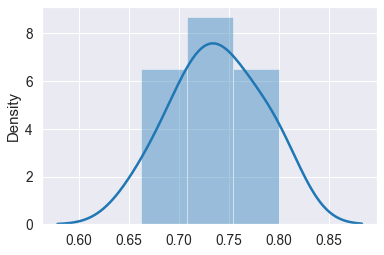

In [14]:
scores = cross_val_score(clf, x_train, y_train, cv=10)
print(f'Mean accuracy: {np.mean(scores)}')
print(f'Std accuracy: {np.std(scores)}')
sns.distplot(scores)

Observe that cross validated accuracies better reflect testing performance!

In [15]:
print(f'Train accuracy: {clf.score(x_train, y_train)}')
print(f'Mean CV accuracy: {np.mean(scores)}')
print(f'Test accuracy: {clf.score(x_test, y_test)}')

Train accuracy: 0.7655571635311144
Mean CV accuracy: 0.7378206065034709
Test accuracy: 0.6883116883116883


## Visualizing the Decision Tree

As mentioned in the lecture, one advantage is that the decision tree can be visualized to see how it arrives at the decision. Let us see how our tree model arrives at a diagnosis of diabetes.

We will use the `plot_tree` from `sklearn.tree` to achieve this. Alternatively, you can also use the [`graphviz` package](https://www.graphviz.org).

In [20]:
from sklearn.tree import plot_tree

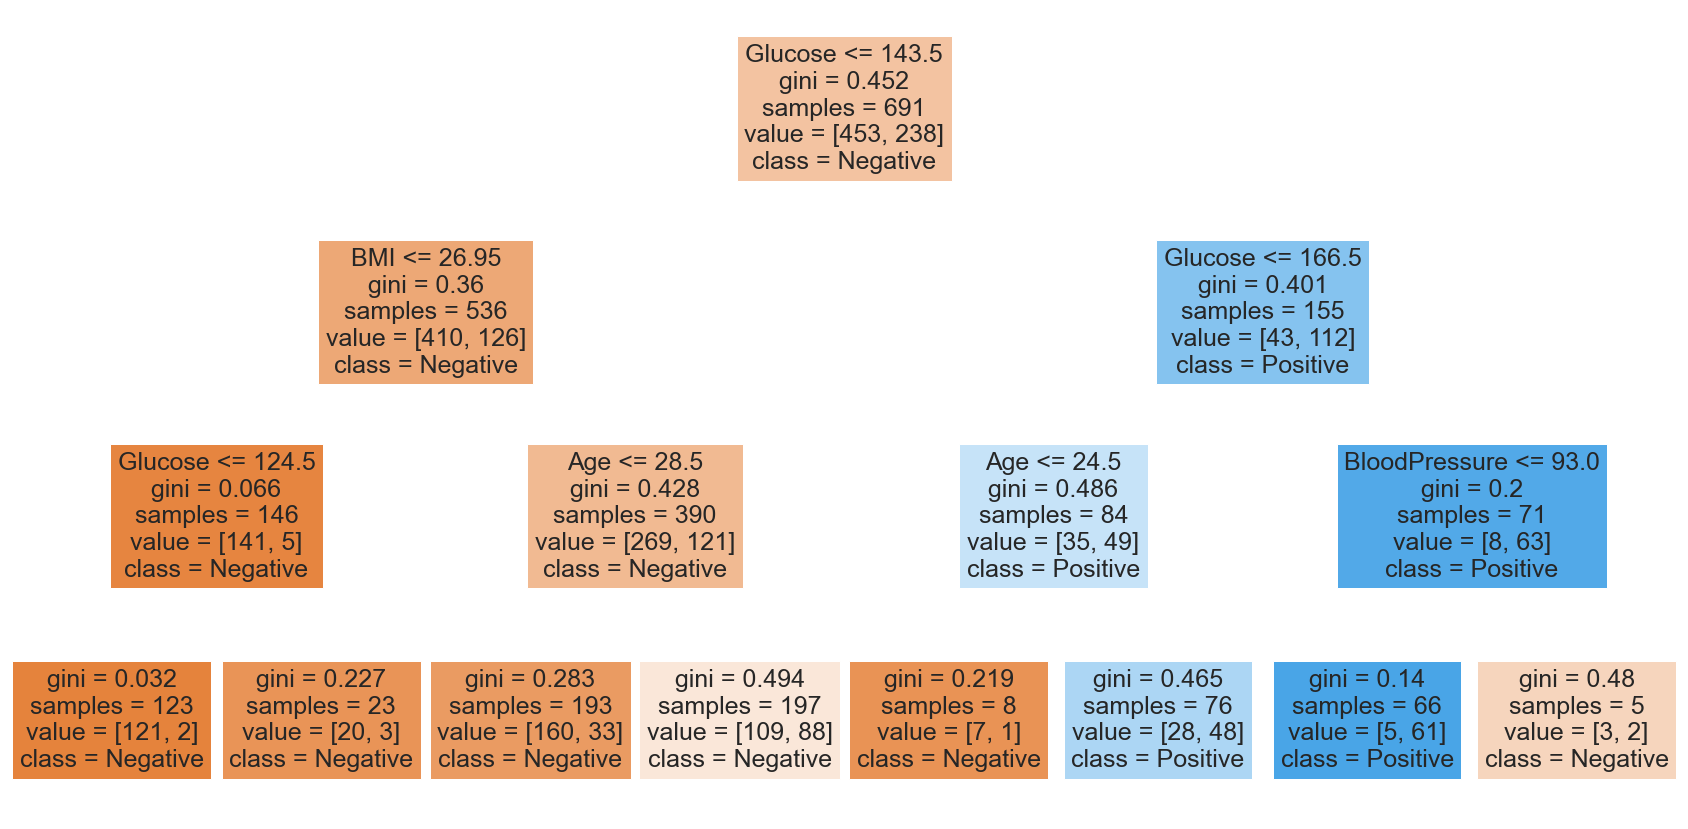

In [21]:
plt.figure(figsize=(30, 15))
plot_tree(
    clf,
    feature_names=dataset.columns[:-1],
    class_names=['Negative', 'Positive'],
    filled=True,
    fontsize=25
);

## Overfitting

Let us now fit a sequence of decision trees with increasing depth. We observe from the results below two things:
  1. As depth increases, we overfit: training accuracy increases but not test
  2. Generally, CV accuracy gives a better prediction of test error

In [22]:
results = []
for depth in range(2, 8):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(x_train, y_train)
    train_acc = clf.score(x_train, y_train)
    test_acc = clf.score(x_test, y_test)
    cv_acc = np.mean(cross_val_score(clf, x_train, y_train, cv=10))
    results.append([depth, train_acc, test_acc, cv_acc])
results = pd.DataFrame(
    data=results,
    columns=['depth', 'train accuracy', 'test accuracy', 'cv accuracy'],
)
results = pd.melt(
    results,
    id_vars=['depth'],
    var_name='type',
    value_name='accuracy'
)  # Melt dataframe for easier plotting

<AxesSubplot:xlabel='depth', ylabel='accuracy'>

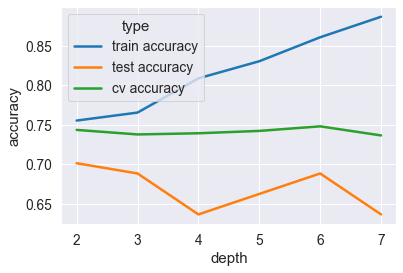

In [23]:
sns.lineplot(
    x='depth',
    y='accuracy',
    hue='type',
    data=results,
)

# Random Forest (Bagging)

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
print(f'Train accuracy: {clf.score(x_train, y_train)}')
scores = cross_val_score(clf, x_train, y_train, cv=10)
print(f'Mean CV accuracy: {np.mean(scores)}')
print(f'Test accuracy: {clf.score(x_test, y_test)}')

Train accuracy: 0.7916063675832128
Mean CV accuracy: 0.7610120569967117
Test accuracy: 0.7012987012987013


In [35]:
results_rf = []
for depth in range(2, 8):
    clf = RandomForestClassifier(n_estimators=100, max_depth=depth)
    clf.fit(x_train, y_train)
    train_acc = clf.score(x_train, y_train)
    test_acc = clf.score(x_test, y_test)
    cv_acc = np.mean(cross_val_score(clf, x_train, y_train, cv=10))
    results_rf.append([depth, train_acc, test_acc, cv_acc])
results_rf = pd.DataFrame(
    data=results_rf,
    columns=['depth', 'train accuracy', 'test accuracy', 'cv accuracy'],
)
results_rf = pd.melt(
    results_rf,
    id_vars=['depth'],
    var_name='type',
    value_name='accuracy'
)

Text(0.5, 1.0, 'Random Forest')

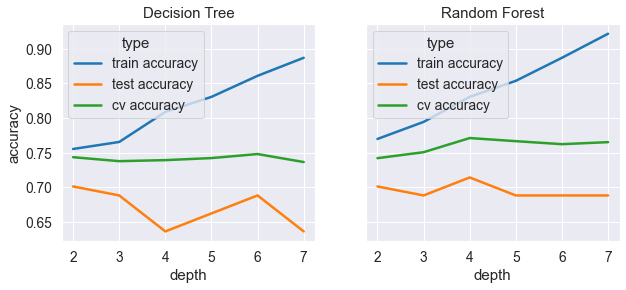

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.lineplot(
    x='depth',
    y='accuracy',
    hue='type',
    data=results,
    ax=ax[0]
)
ax[0].set_title('Decision Tree')

sns.lineplot(
    x='depth',
    y='accuracy',
    hue='type',
    data=results_rf,
    ax=ax[1]
)
ax[1].set_title('Random Forest')

# AdaBoost (Boosting)

In [37]:
from sklearn.ensemble import AdaBoostClassifier

In [38]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=5,
)

In [39]:
clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [40]:
print(f'Train accuracy: {clf.score(x_train, y_train)}')
scores = cross_val_score(clf, x_train, y_train, cv=10)
print(f'Mean CV accuracy: {np.mean(scores)}')
print(f'Test accuracy: {clf.score(x_test, y_test)}')

Train accuracy: 0.7742402315484804
Mean CV accuracy: 0.7536390208257217
Test accuracy: 0.7012987012987013


## Hyper-parameter Tuning

Observe that there are many choices in the `AdaBoost` classifier. We have mostly left everything to their default values.

In [41]:
clf

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In practice, however, to obtain good performance we should perform *hyper-parameter tuning*. This means that we should pick the parameters (e.g. `max_depth`, `criterion`, `learning_rate`, `n_estimators` etc) to maximize performance. 

How do we judge performance? We use cross-validation on the training set!

In [42]:
from sklearn.model_selection import GridSearchCV

First, we check what parameters are adjustable using `clf.get_params()`. 

**Note: make sure you understand what these parameters mean!**

In [43]:
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'learning_rate': 1.0,
 

Next we set up parameter grids and apply `GridSearchCV`. This will take some time...

In [45]:
param_grid = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__criterion': ['gini', 'entropy'],
    'n_estimators': [5, 25, 50],
    'learning_rate': [0.01, 0.1, 1.0],
}

In [46]:
clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=4)

Here the ``cv`` argument is the number of folds of cross validation.

In [47]:
clf_grid.fit(x_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                min

In [48]:
clf_grid.best_params_

{'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'learning_rate': 1.0,
 'n_estimators': 50}

In [49]:
print(f'Train accuracy: {clf_grid.score(x_train, y_train)}')
print(f'Test accuracy: {clf_grid.score(x_test, y_test)}')

Train accuracy: 0.8162083936324168
Test accuracy: 0.7532467532467533


# Final Remarks

So we have improved our results by cross-validation grid search over some hyper-parameters. What if the parameter space is very large so that grid search is impossible? You may check `sklearn.model_selection.RandomizedSearchCV`. 

Another boosting algorithm, namely *gradient boosting*, typically gives state of the art results on a variety of tasks. For details, check the following resources:
   * [Gradient boosting on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
   * [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html): another implementation, generally faster/better than sklearn's
   
Remember to perform hyperparameter tuning! The defaults can be very bad for some applications.